## Collatz omega notebook

In [135]:
"""
This experimental notebook analyses omegas of randomly generated Collatz sequences. Omega is 
defined as the difference between the binary growth (lambda) and the divisions by two (alpha)
in a sequence.
"""

# Fix possible import problems
import sys
sys.path.append("..")

# Imports
import random as rnd
from math import log2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collatz import generator as gen
from collatz import commons as com


# Configuration
MAX_VALUE = 101
K_FACTOR = 3
MAX_ITERATIONS = 100
LOG_MODE = None
PRINT_TABLE = True

START_VALUE = rnd.randint(1, MAX_VALUE)

if START_VALUE % 2 == 0:
    START_VALUE = START_VALUE + 1

# START_VALUE = int('11111111', 2)

pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', 10000)
pd.set_option('display.expand_frame_repr', False)

# Generate Collatz sequence
analysis_frame = gen.generate_odd_collatz_sequence(
    start_value=START_VALUE, k=K_FACTOR, max_iterations=MAX_ITERATIONS)

# Drop last row
analysis_frame = analysis_frame[:-1]

# Derive new fields
analysis_frame["v_1"] = START_VALUE
analysis_frame["n"] = analysis_frame.index + 1
analysis_frame["v_i_log2"] = analysis_frame["collatz"].apply(log2)
analysis_frame["kv_i+1_log2"] = analysis_frame["next_collatz"].apply(log2)
analysis_frame["v_i_log2_frac"] = analysis_frame["v_i_log2"] % 1
analysis_frame["v_i_mod4"] = analysis_frame["collatz"] % 4

analysis_frame["alpha_i"] = analysis_frame["next_collatz"].apply(com.trailing_zeros)
analysis_frame["alpha_i"] = analysis_frame["alpha_i"].astype("int64")
analysis_frame["alpha"] = analysis_frame["alpha_i"].cumsum()

# Lambda
analysis_frame["bin_len"] = analysis_frame["v_i_log2"].astype('int64') + 1
analysis_frame["next_bin_len"] = analysis_frame["kv_i+1_log2"].astype('int64') + 1

analysis_frame["bin_diff"] = analysis_frame["next_bin_len"] - analysis_frame["bin_len"]
analysis_frame["lambda_i"] = analysis_frame["bin_diff"]
analysis_frame.loc[analysis_frame["lambda_i"] < 0, "lambda_i"] = 0
analysis_frame["lambda"] = analysis_frame["lambda_i"].cumsum()

analysis_frame["lambda_i_min"] = int(log2(K_FACTOR))
analysis_frame["lambda_i_max"] = int(log2(K_FACTOR) + 1)

analysis_frame["lambda_hyp"] = (analysis_frame["n"] * log2(K_FACTOR))
analysis_frame["lambda_min"] = analysis_frame["lambda_hyp"].astype('int64')
analysis_frame["lambda_max"] = analysis_frame["lambda_hyp"].astype('int64') + 2

 # Omega
analysis_frame["omega_i"] = analysis_frame["lambda_i"] - analysis_frame["alpha_i"]
analysis_frame["omega"] = analysis_frame["lambda"] - analysis_frame["alpha"]
analysis_frame["omega_i_positive"] = np.where(analysis_frame["omega_i"] > 0, 1, 0)

analysis_frame["omega_i_max"] = analysis_frame["lambda_i_max"] - 1
analysis_frame["omega_max"] = analysis_frame["lambda_max"] - analysis_frame["n"]

analysis_frame["v_i_log2"].astype('int64') + 1
max_bin_len = int(analysis_frame["bin_len"].max())
analysis_frame["bin_str"] = analysis_frame["collatz"].apply(com.to_binary).str.zfill(max_bin_len)

analysis_frame["b2"] = analysis_frame["bin_str"].str[max_bin_len-2]
analysis_frame["b3"] = analysis_frame["bin_str"].str[max_bin_len-3]
analysis_frame["b32"] = analysis_frame["b3"].astype('str') + analysis_frame["b2"]

# Validate omega boundaries
o_max_valid = int((analysis_frame["omega_i"] > analysis_frame["omega_i_max"]).sum()) < 1
o_max_valid &= int((analysis_frame["omega"] > analysis_frame["omega_max"]).sum()) < 1

# Calculate means
o_i_mean = round(analysis_frame["omega_i"].mean(), 2)
l_i_mean = round(analysis_frame["lambda_i"].mean(), 2)

# Print results
print_frame = analysis_frame[[
    "n", "collatz", "next_odd", "v_i_log2_frac",
    "lambda_i", "lambda", "lambda_max", "alpha_i", "omega_i", "omega",
    "omega_max", "bin_str", "b3", "b2", "b32"
]]

print_frame.columns = [
    "n", "v_i", "v_i+", "log_frac",
    "l_i", "l", "l_max", "a_i", "o_i", "o",
    "o_max", "bin_str", "b3", "b2", "b32"
]

print("Start value:", START_VALUE, 
      " K:", K_FACTOR, 
      " Omega max valid:", o_max_valid,
      " o_i:", o_i_mean,
      " l_i:", l_i_mean,
      "\n")

if PRINT_TABLE:
    print(print_frame.to_string(index=False), "\n")

Start value: 59  K: 3  Omega max valid: True  o_i: -0.5  l_i: 1.7 

  n  v_i  v_i+  log_frac  l_i   l  l_max  a_i  o_i  o  o_max  bin_str b3 b2 b32
  1   59    89  0.882643    2   2      3    1    1  1      2  0111011  0  1  01
  2   89    67  0.475733    2   4      5    2    0  1      3  1011001  0  0  00
  3   67   101  0.066089    1   5      6    1    0  1      3  1000011  0  1  01
  4  101    19  0.658211    2   7      8    4   -2 -1      4  1100101  1  0  10
  5   19    29  0.247928    1   8      9    1    0 -1      4  0010011  0  1  01
  6   29    11  0.857981    2  10     11    3   -1 -2      5  0011101  1  0  10
  7   11    17  0.459432    2  12     13    1    1 -1      6  0001011  0  1  01
  8   17    13  0.087463    1  13     14    2   -1 -2      6  0010001  0  0  00
  9   13     5  0.700440    2  15     16    3   -1 -3      7  0001101  1  0  10
 10    5     1  0.321928    2  17     17    4   -2 -5      7  0000101  1  0  10 



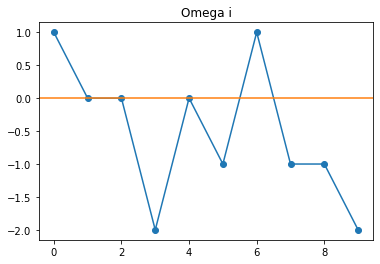

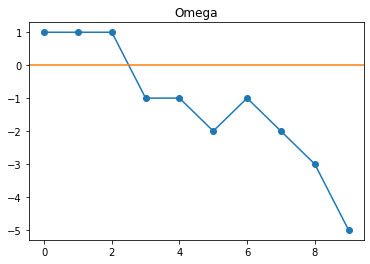

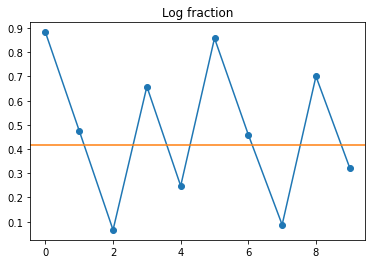

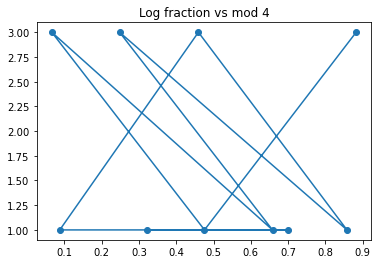

In [136]:
#Plot results
# Omega
plt.figure()
plt.title("Omega i")
plt.plot(analysis_frame["omega_i"], "-o")
plt.axhline(y=0, xmin=0.0, xmax=1.0, color="tab:orange")

plt.figure()
plt.title("Omega")
plt.plot(analysis_frame["omega"], "-o")
plt.axhline(y=0, xmin=0.0, xmax=1.0, color="tab:orange")

plt.figure()
plt.title("Log fraction")
plt.plot(analysis_frame["v_i_log2_frac"], "-o")

fraction_line = 1 - (log2(K_FACTOR) % 1)
plt.axhline(y=fraction_line, xmin=0.0, xmax=1.0, color="tab:orange")

plt.figure()
plt.title("Log fraction vs mod 4")
plt.plot(analysis_frame["v_i_log2_frac"], analysis_frame["v_i_mod4"], "-o")

plt.show()